## Import Data and EDA

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta

df = pd.read_csv('spy.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year
0,1993-01-29,25.236158,25.236158,25.110605,25.218222,1003200,29,4,4,1,1993
1,1993-02-01,25.236146,25.397572,25.236146,25.397572,480500,1,0,5,2,1993
2,1993-02-02,25.379673,25.469354,25.325865,25.451418,201300,2,1,5,2,1993
3,1993-02-03,25.487270,25.738376,25.469334,25.720440,529400,3,2,5,2,1993
4,1993-02-04,25.810132,25.881876,25.523153,25.828068,531500,4,3,5,2,1993


In [5]:
df['RSI'] = ta.rsi(df.Close, length=15)
df['EMAF'] = ta.ema(df.Close, length=20)
df['EMAM'] = ta.ema(df.Close, length=100)
df['EMAS'] = ta.ema(df.Close, length=150)

df['avg'] = (df['High'] + df['Low']) / 2 
df['Tmrw_avg'] = df['avg'].shift(-1)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)

df.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,RSI,EMAF,EMAM,EMAS,avg,Tmrw_avg
0,1993-09-01,26.950641,27.059533,26.950641,27.005087,136500,1,2,35,9,1993,73.860313,26.625405,26.106154,25.902142,27.005087,26.977861
1,1993-09-02,27.023232,27.059530,26.896192,26.914341,472400,2,3,35,9,1993,67.949468,26.652923,26.122157,25.915548,26.977861,26.914327
2,1993-09-03,26.896179,26.968773,26.859882,26.932476,630500,3,4,35,9,1993,68.489414,26.679547,26.138203,25.929018,26.914327,26.841744
3,1993-09-07,26.932487,26.968784,26.714704,26.751001,196400,7,1,36,9,1993,58.011208,26.686352,26.150338,25.939905,26.841744,26.614886
4,1993-09-08,26.751000,26.751000,26.478772,26.660257,269900,8,2,36,9,1993,53.616527,26.683867,26.160435,25.949446,26.614886,26.642101


In [7]:
df['pct'] = df['Tmrw_avg']/df['avg']
df['pct_diff'] = (df['pct'] - 1) * 100

df.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,RSI,EMAF,EMAM,EMAS,avg,Tmrw_avg,pct,pct_diff
0,1993-09-01,26.950641,27.059533,26.950641,27.005087,136500,1,2,35,9,1993,73.860313,26.625405,26.106154,25.902142,27.005087,26.977861,0.998992,-0.100818
1,1993-09-02,27.023232,27.059530,26.896192,26.914341,472400,2,3,35,9,1993,67.949468,26.652923,26.122157,25.915548,26.977861,26.914327,0.997645,-0.235502
2,1993-09-03,26.896179,26.968773,26.859882,26.932476,630500,3,4,35,9,1993,68.489414,26.679547,26.138203,25.929018,26.914327,26.841744,0.997303,-0.269683
3,1993-09-07,26.932487,26.968784,26.714704,26.751001,196400,7,1,36,9,1993,58.011208,26.686352,26.150338,25.939905,26.841744,26.614886,0.991548,-0.845170
4,1993-09-08,26.751000,26.751000,26.478772,26.660257,269900,8,2,36,9,1993,53.616527,26.683867,26.160435,25.949446,26.614886,26.642101,1.001023,0.102254


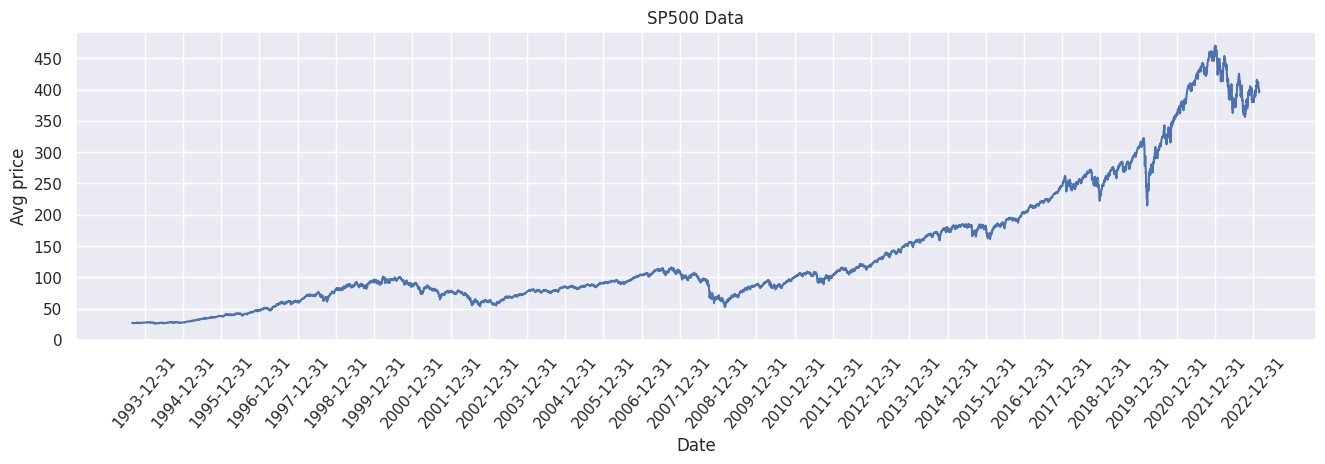

In [8]:
import seaborn as sns
from matplotlib.dates import DateFormatter

date_form = DateFormatter('%Y-%m-%d')

sns.set(rc={'figure.figsize':(16, 4)})
ax = sns.lineplot(x=df['Date'], y=df['avg'])
ax.set_yticks(range(0, 500, 50))
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(df['Date'].min(), df['Date'].max(), freq='Y'), rotation=50)
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

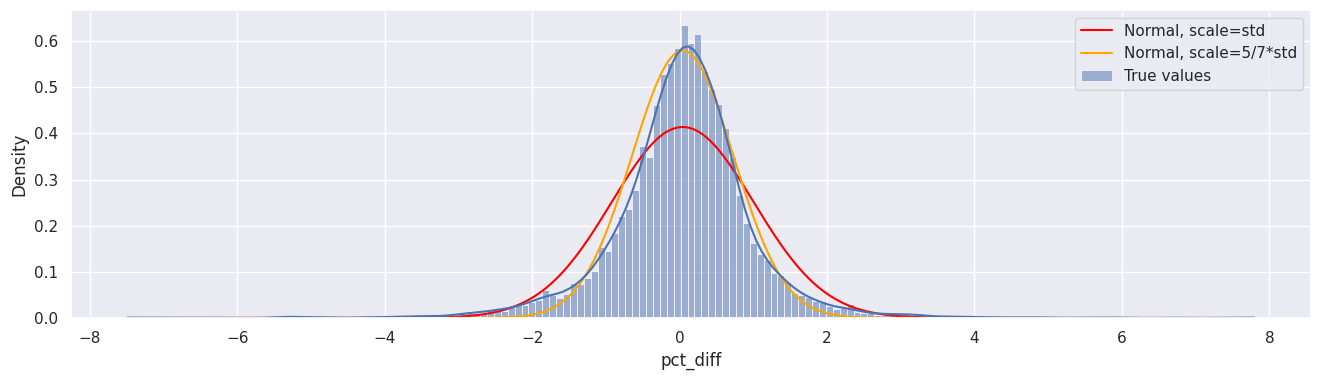

In [9]:
from scipy import stats

mean = df['pct_diff'].mean()
std = df['pct_diff'].std()

x = np.linspace(df['pct_diff'].min(), df['pct_diff'].max(), len(df))
pdf = stats.norm.pdf(x, loc=mean, scale=std)
pdf2 = stats.norm.pdf(x, loc=mean, scale=std*5/7)

sns.lineplot(x=x, y=pdf, color='red', label='Normal, scale=std')
sns.lineplot(x=x, y=pdf2, color='orange', label='Normal, scale=5/7*std')
sns.histplot(df['pct_diff'], stat='density', kde=True, label='True values')
plt.legend()
plt.show()

## Forecasting predicted averages

### LSTM

In [10]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

2023-05-06 16:43:12.919867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-06 16:43:12.946461: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-06 16:43:12.946709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 16:43:13.439682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
def rmse_calc(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse

def mape_calc(y_true, y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape

In [12]:
split = int(len(df)*.8)

x = df.drop(['Tmrw_avg', 'pct', 'pct_diff', 'RSI', 'EMAF', 'EMAM', 'EMAS'], axis=1)
y = df['Tmrw_avg']
y = y.values.reshape(-1,1)

x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

train_dates = x_train['Date']
test_dates = x_test['Date']
x_test = x_test.drop('Date', axis=1)
x_train = x_train.drop('Date', axis=1)

In [13]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [14]:
x_train_lstm = []
x_test_lstm = []
timesteps = 20

for i in range(x_train_scaled[0].size):
    x_train_lstm.append([])
    x_test_lstm.append([])
    for j in range(timesteps, x_train_scaled.shape[0]):
        x_train_lstm[i].append(x_train_scaled[j-timesteps:j, i])
    for j in range(timesteps, x_test_scaled.shape[0]):
        x_test_lstm[i].append(x_test_scaled[j-timesteps:j, i])

x_train_lstm = np.moveaxis(x_train_lstm, [0], [2])
x_test_lstm = np.moveaxis(x_test_lstm, [0], [2])

y_train_lstm = np.array(y_train_scaled[timesteps:,-1])
y_test_lstm = np.array(y_test_scaled[timesteps:,-1])

y_train_lstm = y_train_lstm.reshape(len(y_train_lstm),1)
y_test_lstm = y_test_lstm.reshape(len(y_test_lstm),1)

train_dates_lstm = np.array(train_dates[timesteps:])
test_dates_lstm = np.array(test_dates[timesteps:])


In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, mode='min')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
model = Sequential()
model.add(LSTM(64, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train_lstm, y_train_lstm, epochs=1000, batch_size=50, validation_data=(x_test_lstm, y_test_lstm), shuffle=False, verbose=2, callbacks=[early_stop, checkpoint])

Epoch 1/1000


2023-05-06 16:43:14.228795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 16:43:14.229718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 16:43:14.230412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 - 2s - loss: 0.0086 - val_loss: 0.2077 - 2s/epoch - 15ms/step
Epoch 2/1000


2023-05-06 16:43:15.926937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 16:43:15.928012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 16:43:15.928729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 - 1s - loss: 0.0056 - val_loss: 0.0722 - 516ms/epoch - 4ms/step
Epoch 3/1000
119/119 - 1s - loss: 0.0019 - val_loss: 0.0445 - 528ms/epoch - 4ms/step
Epoch 4/1000
119/119 - 1s - loss: 0.0018 - val_loss: 0.0561 - 517ms/epoch - 4ms/step
Epoch 5/1000
119/119 - 1s - loss: 0.0014 - val_loss: 0.0405 - 507ms/epoch - 4ms/step
Epoch 6/1000
119/119 - 0s - loss: 0.0015 - val_loss: 0.0428 - 489ms/epoch - 4ms/step
Epoch 7/1000
119/119 - 0s - loss: 0.0012 - val_loss: 0.0309 - 496ms/epoch - 4ms/step
Epoch 8/1000
119/119 - 0s - loss: 0.0014 - val_loss: 0.0674 - 487ms/epoch - 4ms/step
Epoch 9/1000
119/119 - 0s - loss: 0.0012 - val_loss: 0.0542 - 487ms/epoch - 4ms/step
Epoch 10/1000
119/119 - 0s - loss: 0.0010 - val_loss: 0.0304 - 499ms/epoch - 4ms/step
Epoch 11/1000
119/119 - 0s - loss: 0.0011 - val_loss: 0.0375 - 488ms/epoch - 4ms/step
Epoch 12/1000
119/119 - 0s - loss: 0.0010 - val_loss: 0.0361 - 488ms/epoch - 4ms/step
Epoch 13/1000
119/119 - 0s - loss: 9.9759e-04 - val_loss: 0.0152 - 496ms/ep

In [17]:
best_model = load_model('best_model.h5')
y_pred = best_model.predict(x_test_lstm)


2023-05-06 16:44:18.162828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 16:44:18.163850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 16:44:18.164584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

46/46 [==============================] - 0s 1ms/step


In [18]:
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test_lstm)

mse = np.mean((y_pred_inv - y_test_inv)**2)

print('LSTM Scores')
print(f'MSE:  {mse:.3f}')
print(f'MAE:  {mean_absolute_error(y_test_inv, y_pred_inv):.3f}')
print(f'RMSE: {rmse_calc(y_test_inv, y_pred_inv):.3f}')
print(f'MAPE: {mape_calc(y_test_inv, y_pred_inv):.3f}')

LSTM Scores
MSE:  545.694
MAE:  16.177
RMSE: 23.360
MAPE: 0.043


In [19]:
perf = [{'Model': 'LSTM', 'Target': 'Price', 'MSE': mse, 'MAE': mean_absolute_error(y_test_inv, y_pred_inv), 'MAPE': mape_calc(y_test_inv, y_pred_inv), 'RMSE': rmse_calc(y_test_inv, y_pred_inv), 'R2': np.nan}]

perf_df = pd.DataFrame(perf)

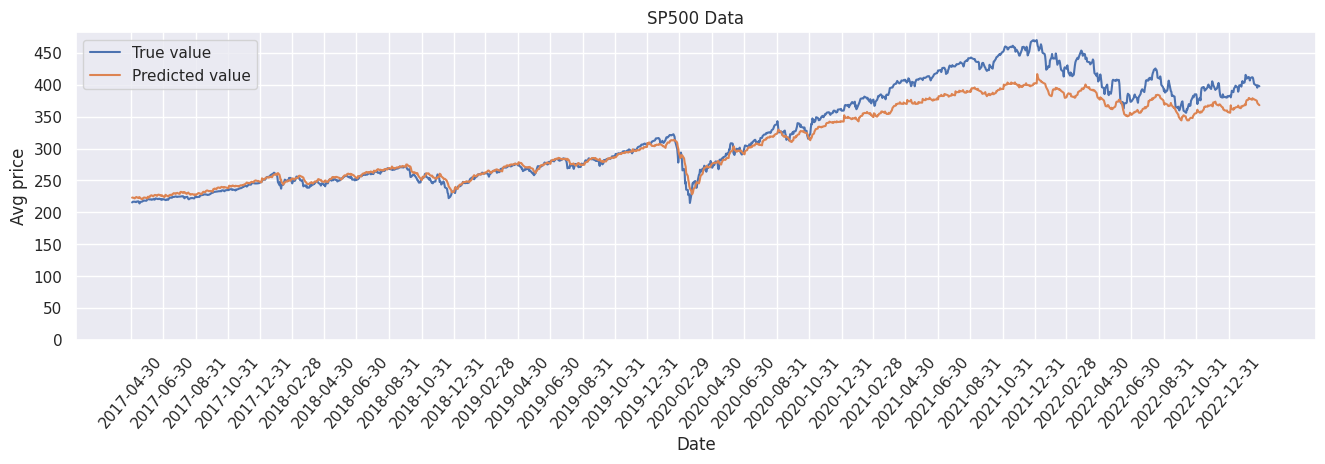

In [20]:
sns.set(rc={'figure.figsize':(16, 4)})
sns.lineplot(x=test_dates_lstm, y=y_test_inv.flatten(), label=f'True value')
sns.lineplot(x=test_dates_lstm, y=y_pred_inv.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

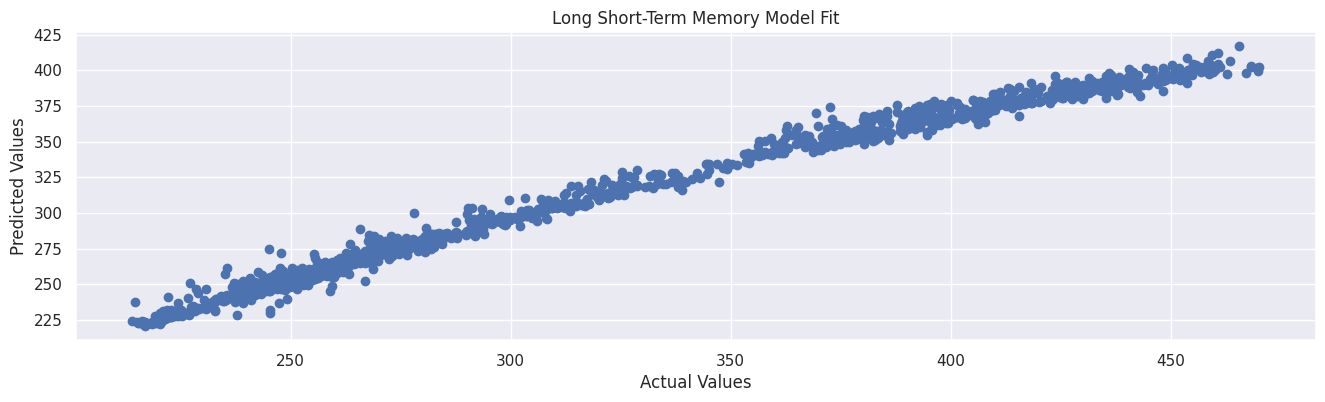

In [21]:
plt.scatter(y_test_inv, y_pred_inv)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Long Short-Term Memory Model Fit')
plt.show()

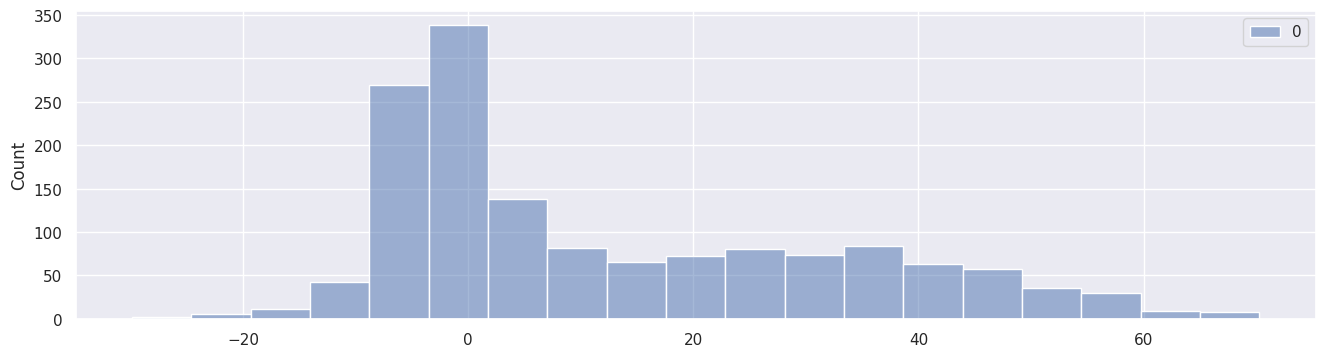

In [22]:
error = y_test_inv - y_pred_inv

sns.histplot(error)

plt.show()

In [24]:
pd.__version__

'2.0.1'

### Linear Regression

Linear regression scores
R-squared: 0.999
MSE: 7.866
MAE: 1.845
RMSE: 2.805
MAPE: 0.006


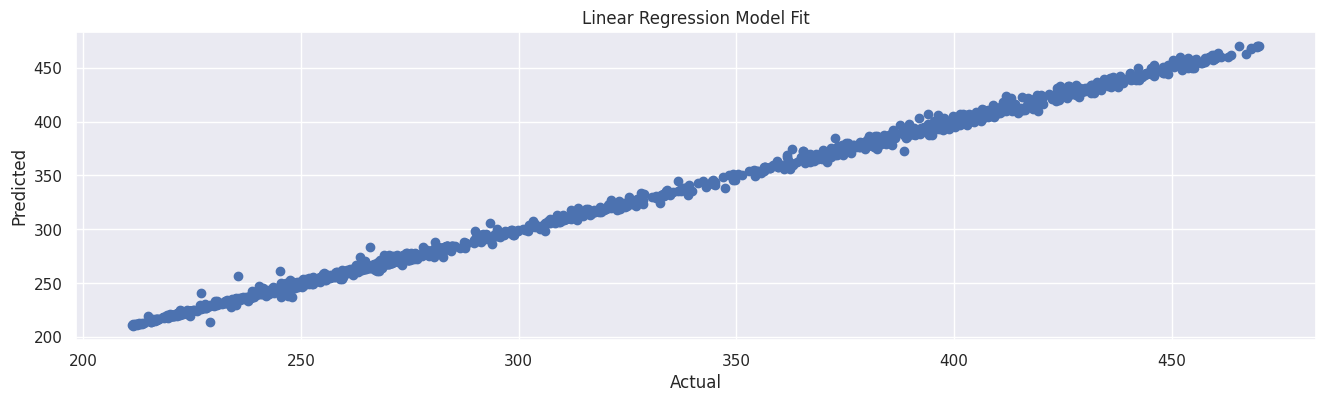

In [27]:
# Linear Regression - Import library
from sklearn.linear_model import LinearRegression

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(x_train_scaled.reshape(x_train_scaled.shape[0], -1), y_train_scaled)
lr_pred = lr_model.predict(x_test_scaled.reshape(x_test_scaled.shape[0], -1))
lr_pred = scaler_y.inverse_transform(lr_pred)

lr_mse = np.mean((lr_pred - y_test)**2)
lr_mae = mean_absolute_error(y_test, lr_pred)

# Calculate R-squared 
lr_r2 = r2_score(y_test, lr_pred)

# Print Linear Regression Mean Squared Error, Mean Absolute Error, and R-squared
print('Linear regression scores')
print(f'R-squared: {lr_r2:.3f}')
print(f'MSE: {lr_mse:.3f}')
print(f'MAE: {lr_mae:.3f}')
print(f'RMSE: {rmse_calc(y_test, lr_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, lr_pred):.3f}')

perf = [{'Model': 'LR', 'Target': 'Price', 'MSE': lr_mse, 'MAE': lr_mae, 'MAPE': mape_calc(y_test, lr_pred), 'RMSE': rmse_calc(y_test, lr_pred), 'R2': lr_r2}]
new_row = pd.DataFrame(perf)
perf_df = pd.concat([perf_df, new_row], ignore_index=True)

# Create scatterplot with model fit
plt.scatter(y_test, lr_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression Model Fit')
plt.show()

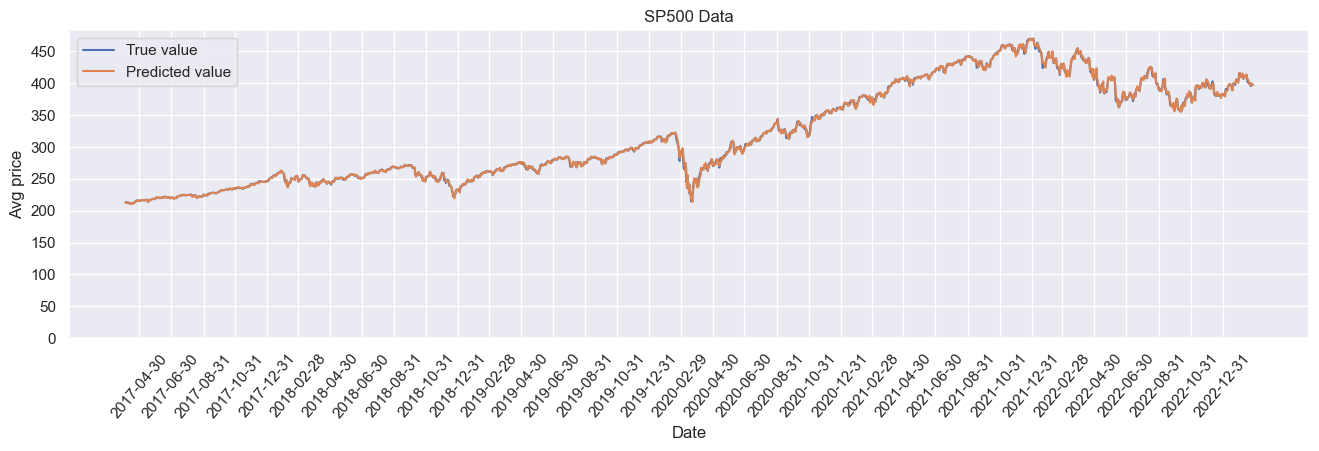

In [ ]:
sns.lineplot(x=test_dates, y=y_test.flatten(), label=f'True value')
sns.lineplot(x=test_dates, y=lr_pred.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

### SVM

SVM Regression scores
R-squared: 0.5872422668443428
MSE: 2345.7899558459226
MAE: 44.34346207640726
RMSE: 48.433
MAPE: 0.132


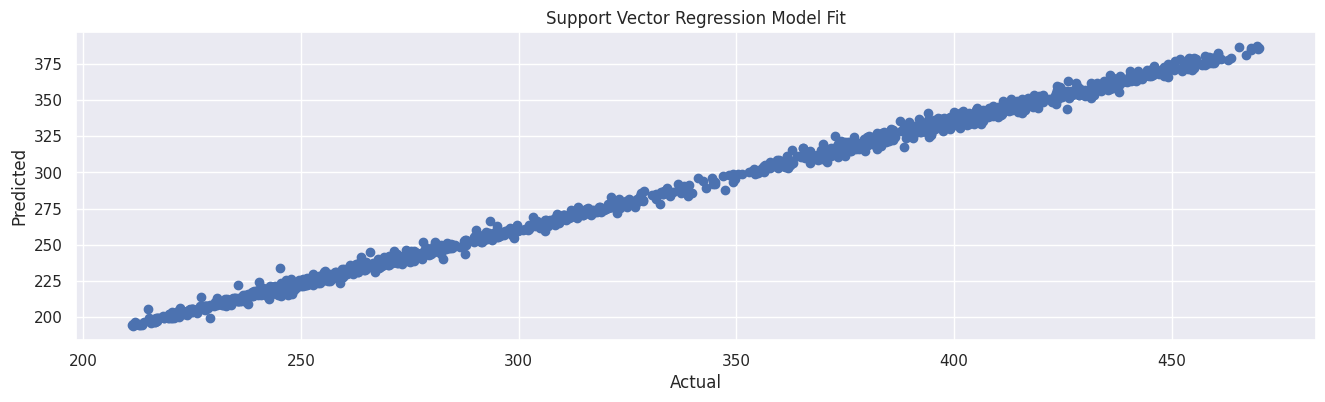

In [29]:
# Support Vector Regression - Import library
from sklearn.svm import SVR

# Support Vector Regression
svm_model = SVR(kernel='linear')
svm_model.fit(x_train_scaled.reshape(x_train_scaled.shape[0], -1), y_train_scaled.ravel())
svm_pred = svm_model.predict(x_test_scaled.reshape(x_test_scaled.shape[0], -1))
svm_pred = scaler_y.inverse_transform(svm_pred.reshape(-1, 1))
svm_mse = np.mean((svm_pred - y_test)**2)

# Calculate R-squared and mean absolute error
svm_r2 = r2_score(y_test, svm_pred)
svm_mae = mean_absolute_error(y_test, svm_pred)

# Print SVM Mean Squared Error, Mean Absolute Error and R-squared
print('SVM Regression scores')
print('R-squared:', svm_r2)
print('MSE:', svm_mse)
print('MAE:', svm_mae)
print(f'RMSE: {rmse_calc(y_test, svm_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, svm_pred):.3f}')

perf = [{'Model': 'SVM', 'Target': 'Price', 'MSE': svm_mse, 'MAE': svm_mae, 'MAPE': mape_calc(y_test, svm_pred), 'RMSE': rmse_calc(y_test, svm_pred), 'R2': svm_r2}]
new_row = pd.DataFrame(perf)
perf_df = pd.concat([perf_df, new_row], ignore_index=True)


# Create scatterplot with model fit
plt.scatter(y_test, svm_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Support Vector Regression Model Fit')
plt.show()


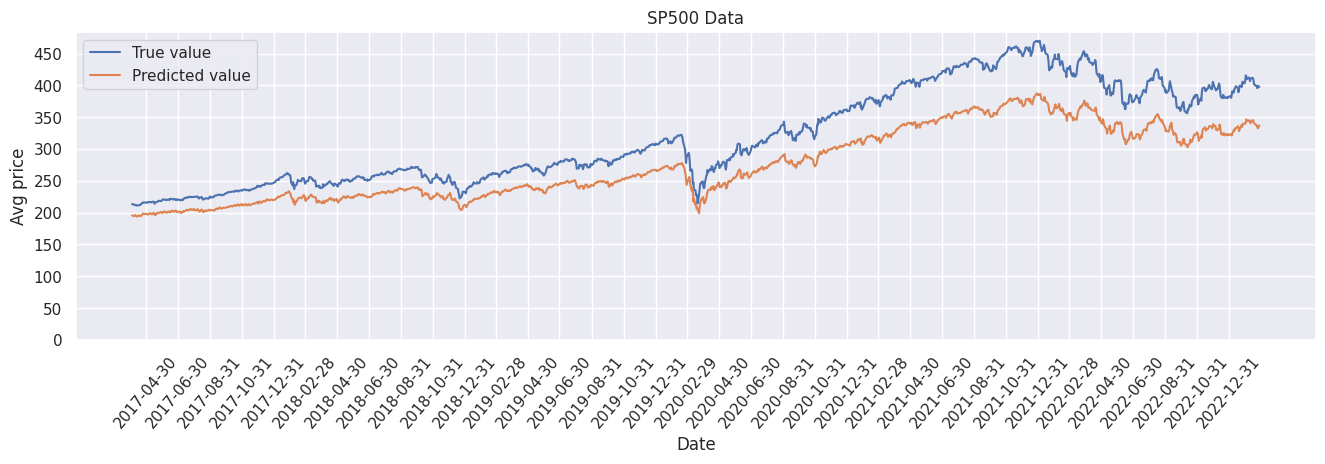

In [30]:
sns.lineplot(x=test_dates, y=y_test.flatten(), label=f'True value')
sns.lineplot(x=test_dates, y=svm_pred.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

### Decision Tree 

Decision Tree regression scores
R-squared: -1.9360581063718878
MSE: 16686.242467345463
MAE: 104.9303617740312
RMSE: 129.175
MAPE: 0.290


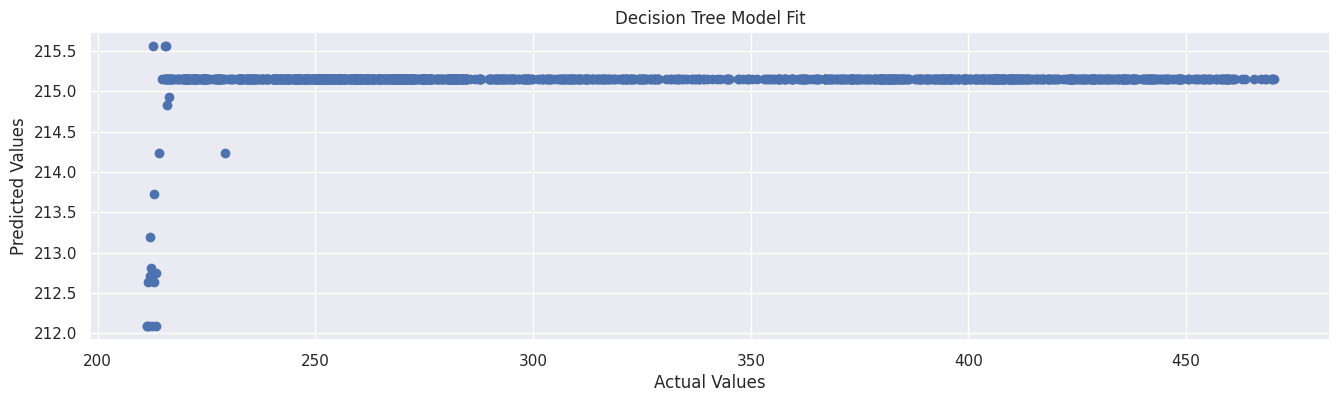

In [31]:
# Decision Tree Regression - Import library
from sklearn.tree import DecisionTreeRegressor

# Decision Tree Regression
dt_model = DecisionTreeRegressor()
dt_model.fit(x_train_scaled.reshape(x_train_scaled.shape[0], -1), y_train_scaled)
dt_pred = dt_model.predict(x_test_scaled.reshape(x_test_scaled.shape[0], -1))
dt_pred = scaler_y.inverse_transform(dt_pred.reshape(-1, 1))
dt_mse = np.mean((dt_pred - y_test)**2)

# Calculate R-squared and mean absolute error
dt_r2 = r2_score(y_test, dt_pred)
dt_mae = mean_absolute_error(y_test, dt_pred)

# Print Decision Tree Mean Squared Error, Mean Absolute Error, and R-squared
print('Decision Tree regression scores')
print('R-squared:', dt_r2)
print('MSE:', dt_mse)
print('MAE:', dt_mae)
print(f'RMSE: {rmse_calc(y_test, dt_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, dt_pred):.3f}')

perf = [{'Model': 'DT', 'Target': 'Price', 'MSE': dt_mse, 'MAE': dt_mae, 'MAPE': mape_calc(y_test, dt_pred), 'RMSE': rmse_calc(y_test, dt_pred), 'R2': dt_r2}]
new_row = pd.DataFrame(perf)
perf_df = pd.concat([perf_df, new_row], ignore_index=True)


# Create scatterplot with model fit
plt.scatter(y_test, dt_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Model Fit')
plt.show()

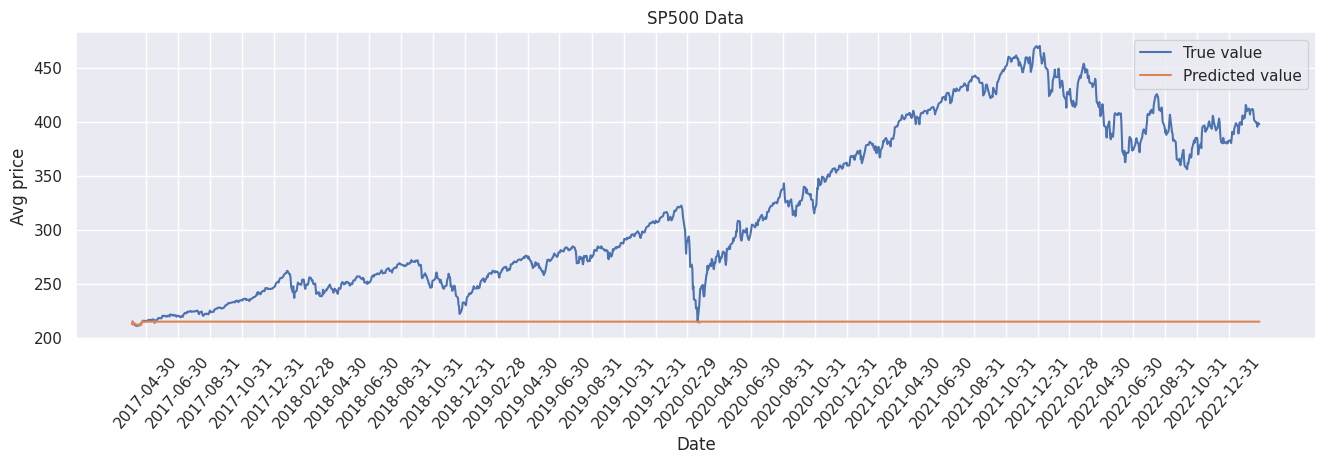

In [32]:
sns.lineplot(x=test_dates, y=y_test.flatten(), label=f'True value')
sns.lineplot(x=test_dates, y=dt_pred.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
#plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

### Gradient Boosting

/home/reedoken/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Grabient Boosting regression scores
MSE: 16871.641552511388
MAE: 105.81348471229677
R-squared: -1.9686803392071481
RMSE: 129.891
MAPE: 0.293


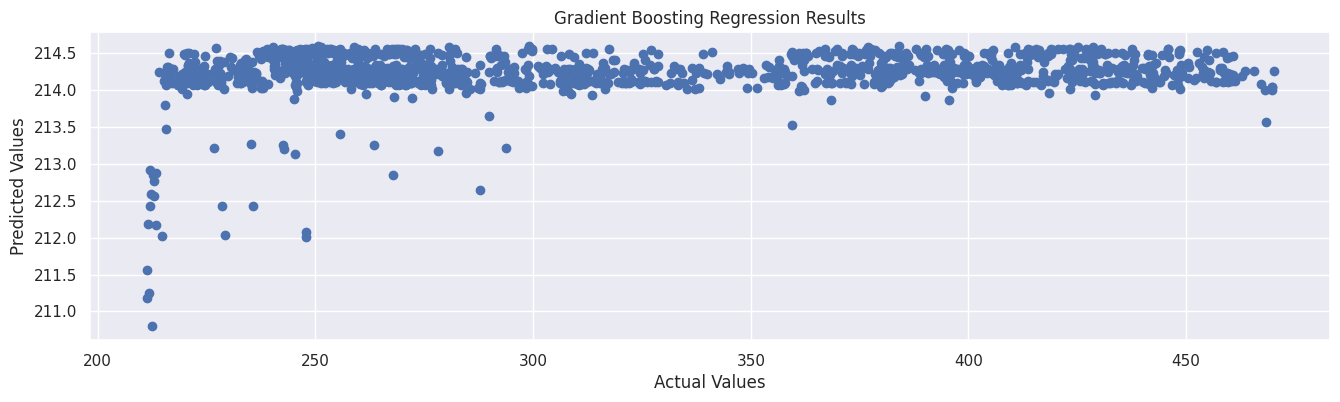

In [33]:
# Gradient Boosting Regression - Import library
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor(n_estimators=100)
gb_model.fit(x_train_scaled.reshape(x_train_scaled.shape[0], -1), y_train_scaled)
gb_pred = gb_model.predict(x_test_scaled.reshape(x_test_scaled.shape[0], -1))
gb_pred = scaler_y.inverse_transform(gb_pred.reshape(-1, 1))
gb_mse = np.mean((gb_pred - y_test)**2)

# Calculate R-squared and mean absolute error
gb_r2 = r2_score(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)

# Print Gradient Boosting Mean Squared Error, Mean Absolute Error, and R-squared
print('Grabient Boosting regression scores')
print('MSE:', gb_mse)
print('MAE:', gb_mae)
print('R-squared:', gb_r2)
print(f'RMSE: {rmse_calc(y_test, gb_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, gb_pred):.3f}')

perf = [{'Model': 'GB', 'Target': 'Price', 'MSE': gb_mse, 'MAE': gb_mae, 'MAPE': mape_calc(y_test, gb_pred), 'RMSE': rmse_calc(y_test, gb_pred), 'R2': gb_r2}]
new_row = pd.DataFrame(perf)
perf_df = pd.concat([perf_df, new_row], ignore_index=True)

# Create scatterplot with model fit
plt.scatter(y_test, gb_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Gradient Boosting Regression Results')
plt.show()

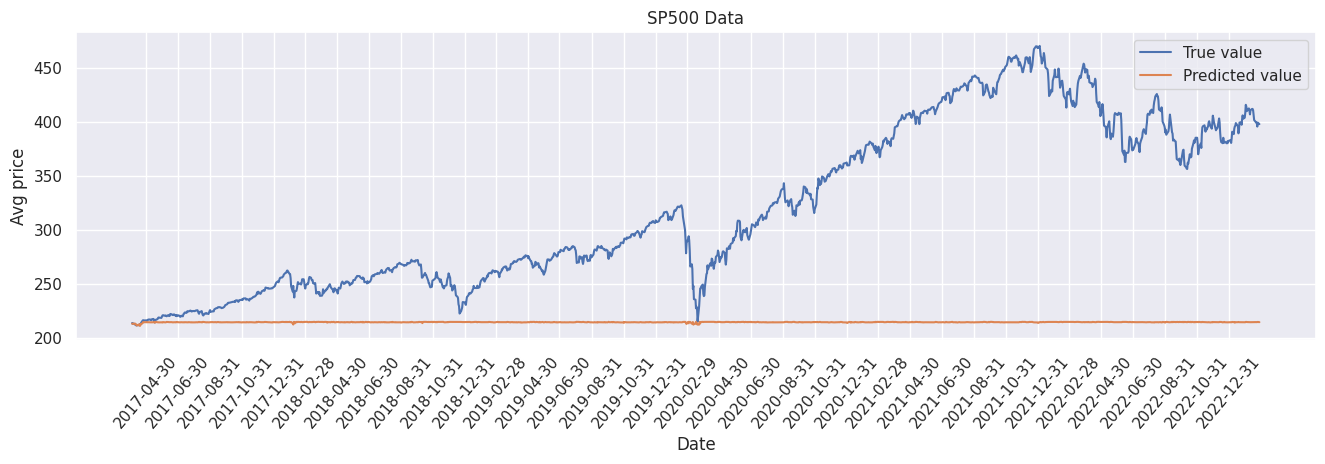

In [34]:
sns.lineplot(x=test_dates, y=y_test.flatten(), label=f'True value')
sns.lineplot(x=test_dates, y=gb_pred.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
#plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

### Random forest

Random Forest regression scores
R-squared: -1.9616233383001656
MSE: 16831.53511593555
MAE: 105.61020223052145
RMSE: 129.736
MAPE: 0.293


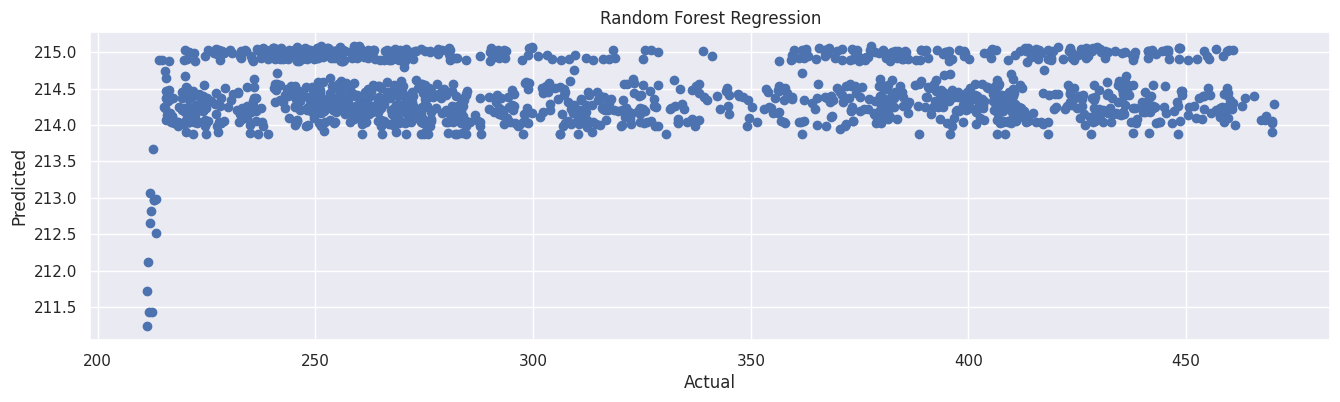

In [35]:
# Random Forest - Import library
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(x_train_scaled.reshape(x_train_scaled.shape[0], -1), y_train_scaled.ravel())
rf_pred = rf_model.predict(x_test_scaled.reshape(x_test_scaled.shape[0], -1))
rf_pred = scaler_y.inverse_transform(rf_pred.reshape(-1, 1))
rf_mse = np.mean((rf_pred - y_test)**2)

# Calculate R-squared and Mean Absolute Error
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

# Print Random Forest Mean Squared Error, Mean Absolute Error, and R-squared
print('Random Forest regression scores')
print('R-squared:', rf_r2)
print('MSE:', rf_mse)
print('MAE:', rf_mae)
print(f'RMSE: {rmse_calc(y_test, rf_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, rf_pred):.3f}')

perf = [{'Model': 'RF', 'Target': 'Price', 'MSE': rf_mse, 'MAE': rf_mae, 'MAPE': mape_calc(y_test, rf_pred), 'RMSE': rmse_calc(y_test, rf_pred), 'R2': rf_r2}]
new_row = pd.DataFrame(perf)
perf_df = pd.concat([perf_df, new_row], ignore_index=True)

# Create scatterplot with model fit
plt.scatter(y_test, rf_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Regression")
plt.show()

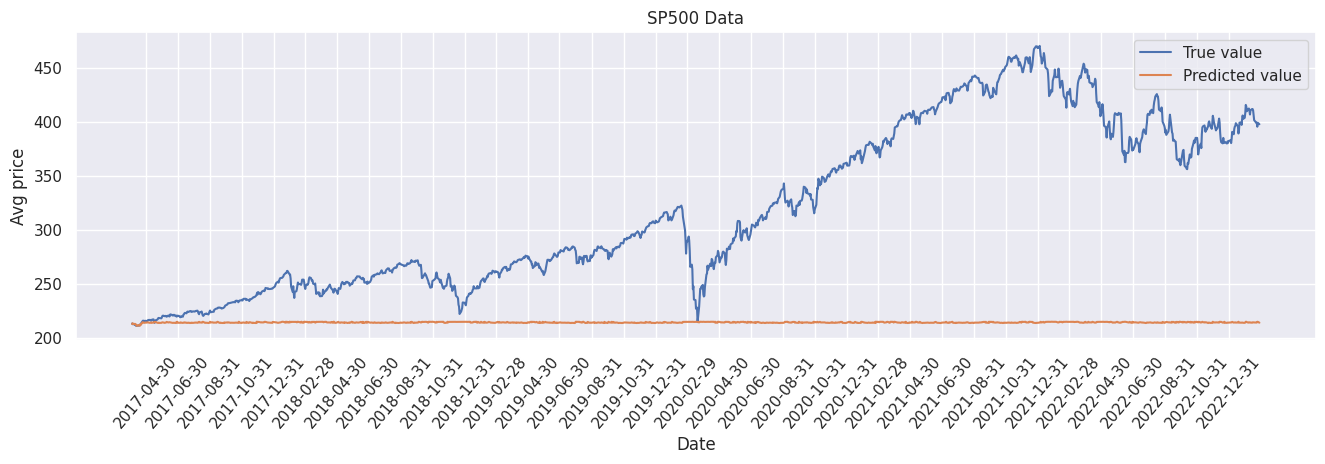

In [36]:
sns.lineplot(x=test_dates, y=y_test.flatten(), label=f'True value')
sns.lineplot(x=test_dates, y=rf_pred.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
#plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

## Predicting percent change

### adjusting testing and training datasets

In [37]:
split = int(len(df)*.8)

x = df.drop(['Tmrw_avg', 'pct', 'pct_diff'], axis=1)
y = df['pct']
y = y.values.reshape(-1,1)

x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

train_dates = x_train['Date']
test_dates = x_test['Date']
x_test = x_test.drop('Date', axis=1)
x_train = x_train.drop('Date', axis=1)

In [38]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [39]:
x_train_lstm = []
x_test_lstm = []
timesteps = 20

for i in range(x_train_scaled[0].size):
    x_train_lstm.append([])
    x_test_lstm.append([])
    for j in range(timesteps, x_train_scaled.shape[0]):
        x_train_lstm[i].append(x_train_scaled[j-timesteps:j, i])
    for j in range(timesteps, x_test_scaled.shape[0]):
        x_test_lstm[i].append(x_test_scaled[j-timesteps:j, i])

x_train_lstm = np.moveaxis(x_train_lstm, [0], [2])
x_test_lstm = np.moveaxis(x_test_lstm, [0], [2])

y_train_lstm = np.array(y_train_scaled[timesteps:,-1])
y_test_lstm = np.array(y_test_scaled[timesteps:,-1])

y_train_lstm = y_train_lstm.reshape(len(y_train_lstm),1)
y_test_lstm = y_test_lstm.reshape(len(y_test_lstm),1)

train_dates_lstm = np.array(train_dates[timesteps:])
test_dates_lstm = np.array(test_dates[timesteps:])


### LSTM

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, mode='min')
checkpoint = ModelCheckpoint('best_model_pct.h5', monitor='val_loss', save_best_only=True)
model = Sequential()
model.add(LSTM(64, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train_lstm, y_train_lstm, epochs=1000, batch_size=50, validation_data=(x_test_lstm, y_test_lstm), shuffle=False, verbose=2, callbacks=[early_stop, checkpoint])

Epoch 1/1000


2023-05-06 17:19:39.564755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 17:19:39.565652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 17:19:39.566330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 - 2s - loss: 0.0166 - val_loss: 0.0058 - 2s/epoch - 14ms/step
Epoch 2/1000


2023-05-06 17:19:41.188958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 17:19:41.189960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 17:19:41.190747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 - 1s - loss: 0.0090 - val_loss: 0.0048 - 550ms/epoch - 5ms/step
Epoch 3/1000
119/119 - 1s - loss: 0.0066 - val_loss: 0.0052 - 522ms/epoch - 4ms/step
Epoch 4/1000
119/119 - 1s - loss: 0.0058 - val_loss: 0.0071 - 503ms/epoch - 4ms/step
Epoch 5/1000
119/119 - 0s - loss: 0.0057 - val_loss: 0.0107 - 497ms/epoch - 4ms/step
Epoch 6/1000
119/119 - 0s - loss: 0.0055 - val_loss: 0.0090 - 492ms/epoch - 4ms/step
Epoch 7/1000
119/119 - 1s - loss: 0.0053 - val_loss: 0.0103 - 508ms/epoch - 4ms/step
Epoch 8/1000
119/119 - 1s - loss: 0.0053 - val_loss: 0.0090 - 514ms/epoch - 4ms/step
Epoch 9/1000
119/119 - 1s - loss: 0.0051 - val_loss: 0.0080 - 528ms/epoch - 4ms/step
Epoch 10/1000
119/119 - 1s - loss: 0.0054 - val_loss: 0.0085 - 529ms/epoch - 4ms/step
Epoch 11/1000
119/119 - 1s - loss: 0.0051 - val_loss: 0.0083 - 520ms/epoch - 4ms/step
Epoch 12/1000
119/119 - 1s - loss: 0.0050 - val_loss: 0.0078 - 519ms/epoch - 4ms/step
Epoch 13/1000
119/119 - 1s - loss: 0.0049 - val_loss: 0.0068 - 518ms/epoch 

In [41]:
best_model = load_model('best_model_pct.h5')
y_pred = best_model.predict(x_test_lstm)


2023-05-06 17:19:49.818199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 17:19:49.819133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 17:19:49.819822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

46/46 [==============================] - 0s 2ms/step


2023-05-06 17:19:50.128530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-06 17:19:50.129623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-06 17:19:50.130395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [43]:
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test_lstm)

mse = np.mean((y_pred_inv - y_test_inv)**2)

print('LSTM Scores')
print(f'MSE:  {mse:.3f}')
print(f'MAE:  {mean_absolute_error(y_test_inv, y_pred_inv):.3f}')
print(f'RMSE: {rmse_calc(y_test_inv, y_pred_inv):.3f}')
print(f'MAPE: {mape_calc(y_test_inv, y_pred_inv):.3f}')

perf = [{'Model': 'LSTM', 'Target': 'Pct', 'MSE': mse, 'MAE': mean_absolute_error(y_test_inv, y_pred_inv), 'MAPE': mape_calc(y_test_inv, y_pred_inv), 'RMSE': rmse_calc(y_test_inv, y_pred_inv), 'R2': np.nan}]
new_row = pd.DataFrame(perf)
perf_df = pd.concat([perf_df, new_row], ignore_index=True)

LSTM Scores
MSE:  0.000
MAE:  0.007
RMSE: 0.011
MAPE: 0.007


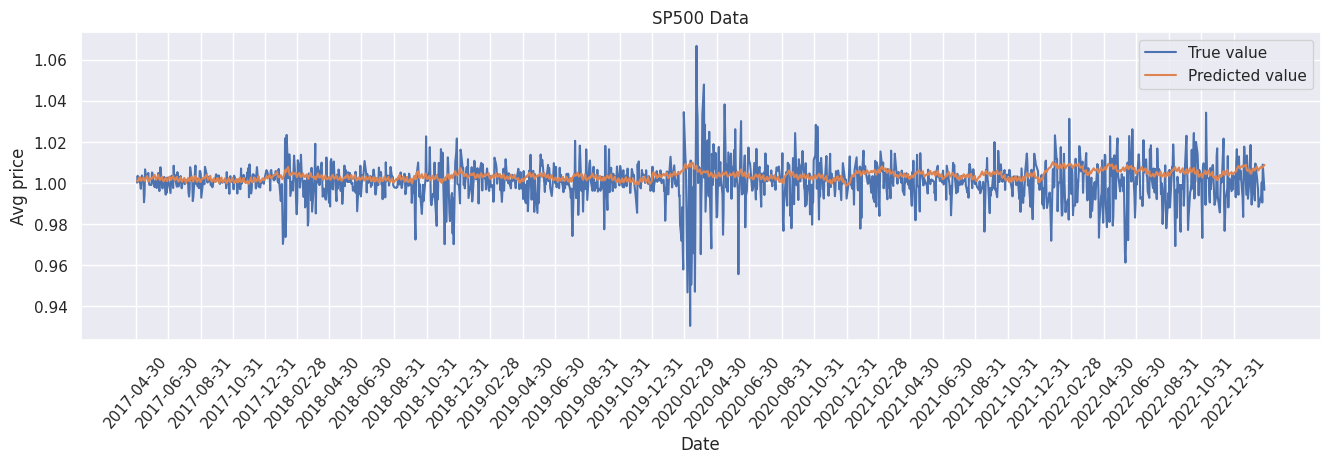

In [44]:
sns.set(rc={'figure.figsize':(16, 4)})
sns.lineplot(x=test_dates_lstm, y=y_test_inv.flatten(), label=f'True value')
sns.lineplot(x=test_dates_lstm, y=y_pred_inv.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
#plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

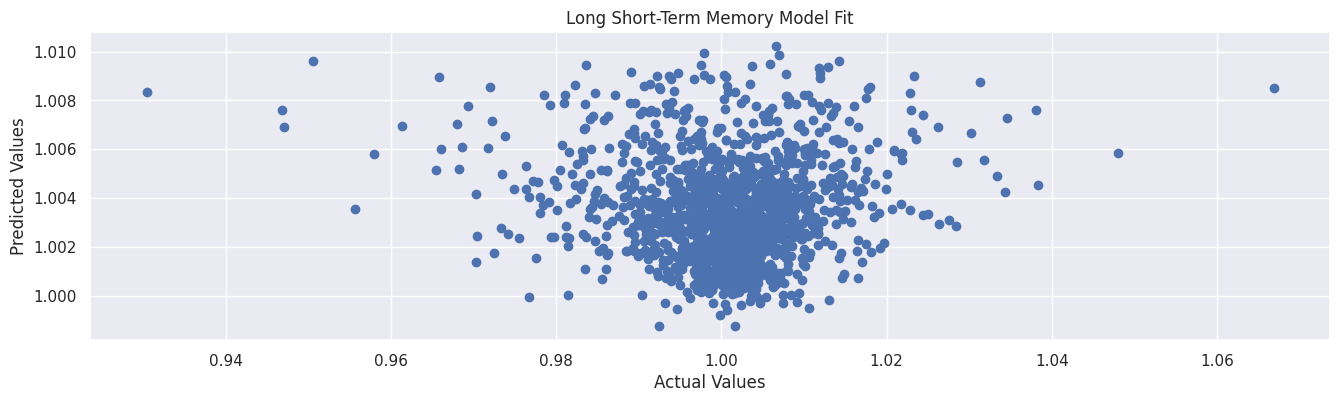

In [45]:
plt.scatter(y_test_inv, y_pred_inv)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Long Short-Term Memory Model Fit')
plt.show()

<Axes: ylabel='Count'>

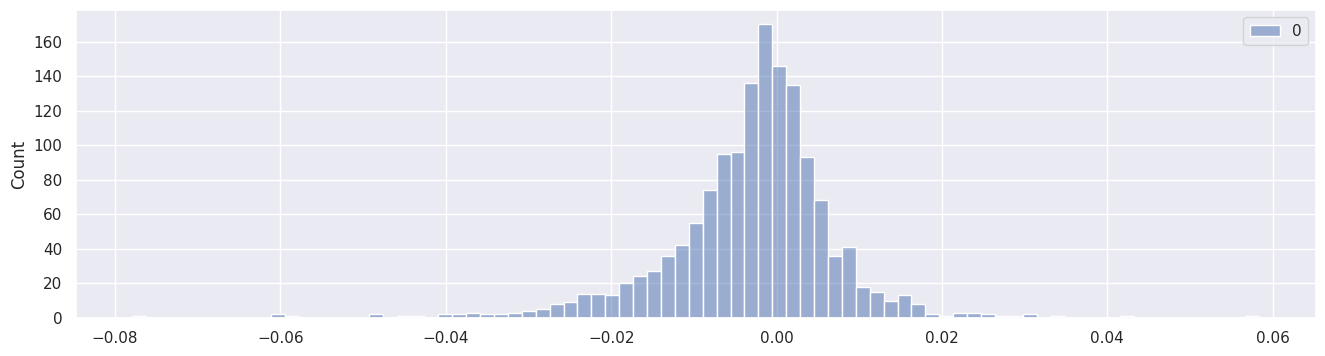

In [46]:
error = y_test_inv - y_pred_inv

sns.histplot(error)

### Linear Regression

Linear regression scores
R-squared: -2.140
MSE: 0.000
MAE: 0.011
RMSE: 0.017
MAPE: 0.011


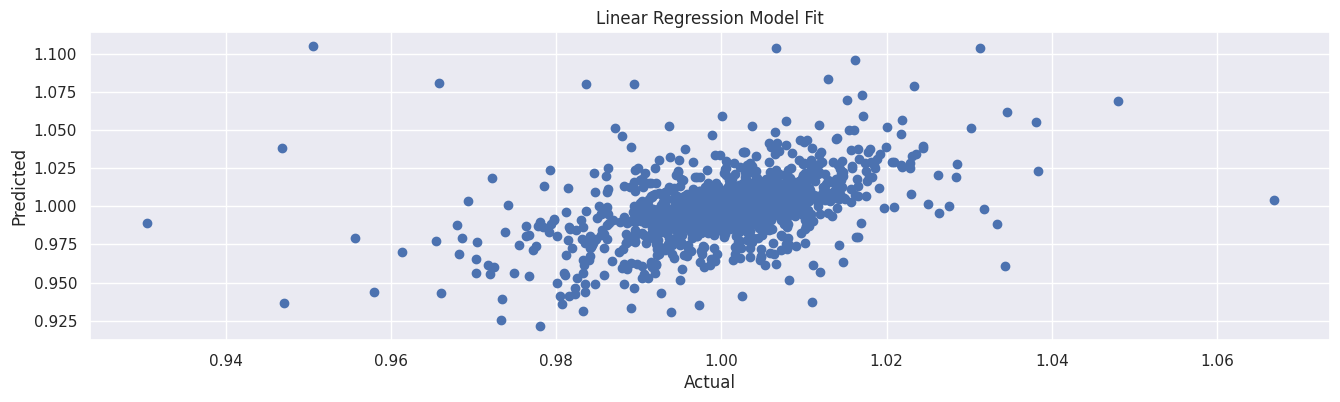

In [47]:
# Linear Regression - Import library
from sklearn.linear_model import LinearRegression

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(x_train_scaled.reshape(x_train_scaled.shape[0], -1), y_train_scaled)
lr_pred = lr_model.predict(x_test_scaled.reshape(x_test_scaled.shape[0], -1))
lr_pred = scaler_y.inverse_transform(lr_pred)

lr_mse = np.mean((lr_pred - y_test)**2)
lr_mae = mean_absolute_error(y_test, lr_pred)

# Calculate R-squared 
lr_r2 = r2_score(y_test, lr_pred)

# Print Linear Regression Mean Squared Error, Mean Absolute Error, and R-squared
print('Linear regression scores')
print(f'R-squared: {lr_r2:.3f}')
print(f'MSE: {lr_mse:.3f}')
print(f'MAE: {lr_mae:.3f}')
print(f'RMSE: {rmse_calc(y_test, lr_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, lr_pred):.3f}')

perf = [{'Model': 'LR', 'Target': 'Pct', 'MSE': lr_mse, 'MAE': lr_mae, 'MAPE': mape_calc(y_test, lr_pred), 'RMSE': rmse_calc(y_test, lr_pred), 'R2': lr_r2}]
new_row = pd.DataFrame(perf)
perf_df = pd.concat([perf_df, new_row], ignore_index=True)

# Create scatterplot with model fit
plt.scatter(y_test, lr_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression Model Fit')
plt.show()

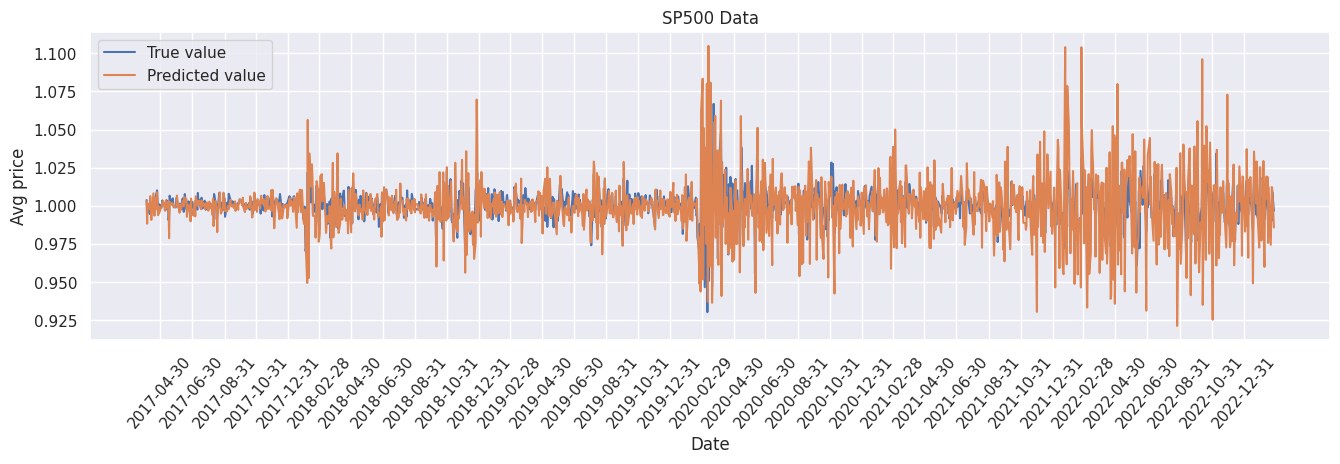

In [48]:
sns.lineplot(x=test_dates, y=y_test.flatten(), label=f'True value')
sns.lineplot(x=test_dates, y=lr_pred.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
#plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

### SVM

SVM Regression scores
R-squared: -0.002779893554113455
MSE: 9.725886005147249e-05
MAE: 0.006564372349675416
RMSE: 0.010
MAPE: 0.007


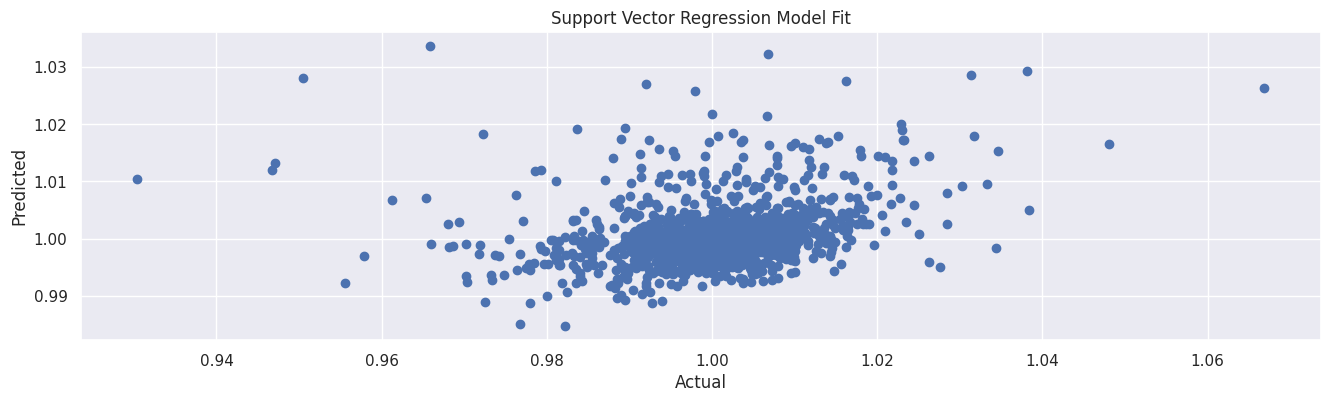

In [49]:
# Support Vector Regression - Import library
from sklearn.svm import SVR

# Support Vector Regression
svm_model = SVR(kernel='linear')
svm_model.fit(x_train_scaled.reshape(x_train_scaled.shape[0], -1), y_train_scaled.ravel())
svm_pred = svm_model.predict(x_test_scaled.reshape(x_test_scaled.shape[0], -1))
svm_pred = scaler_y.inverse_transform(svm_pred.reshape(-1, 1))
svm_mse = np.mean((svm_pred - y_test)**2)

# Calculate R-squared and mean absolute error
svm_r2 = r2_score(y_test, svm_pred)
svm_mae = mean_absolute_error(y_test, svm_pred)

# Print SVM Mean Squared Error, Mean Absolute Error and R-squared
print('SVM Regression scores')
print('R-squared:', svm_r2)
print('MSE:', svm_mse)
print('MAE:', svm_mae)
print(f'RMSE: {rmse_calc(y_test, svm_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, svm_pred):.3f}')

perf = [{'Model': 'SVM', 'Target': 'Pct', 'MSE': svm_mse, 'MAE': svm_mae, 'MAPE': mape_calc(y_test, svm_pred), 'RMSE': rmse_calc(y_test, svm_pred), 'R2': svm_r2}]
new_row = pd.DataFrame(perf)
perf_df = pd.concat([perf_df, new_row], ignore_index=True)

# Create scatterplot with model fit
plt.scatter(y_test, svm_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Support Vector Regression Model Fit')
plt.show()


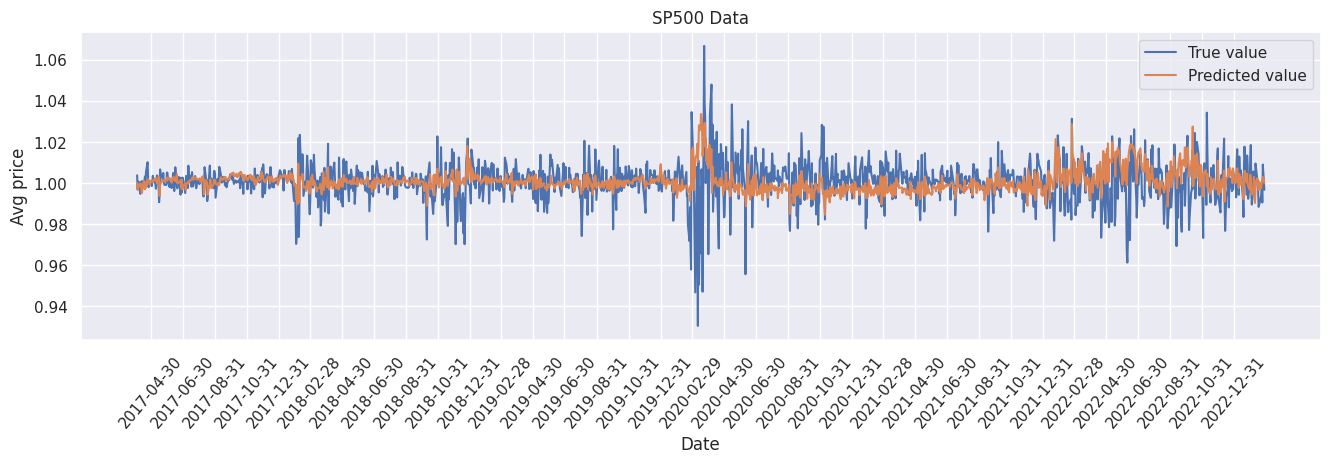

In [50]:
sns.lineplot(x=test_dates, y=y_test.flatten(), label=f'True value')
sns.lineplot(x=test_dates, y=svm_pred.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
#plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

### Decision Tree 

Decision Tree regression scores
R-squared: -0.8501173216638274
MSE: 0.00017944147347106446
MAE: 0.009508287709718578
RMSE: 0.013
MAPE: 0.010


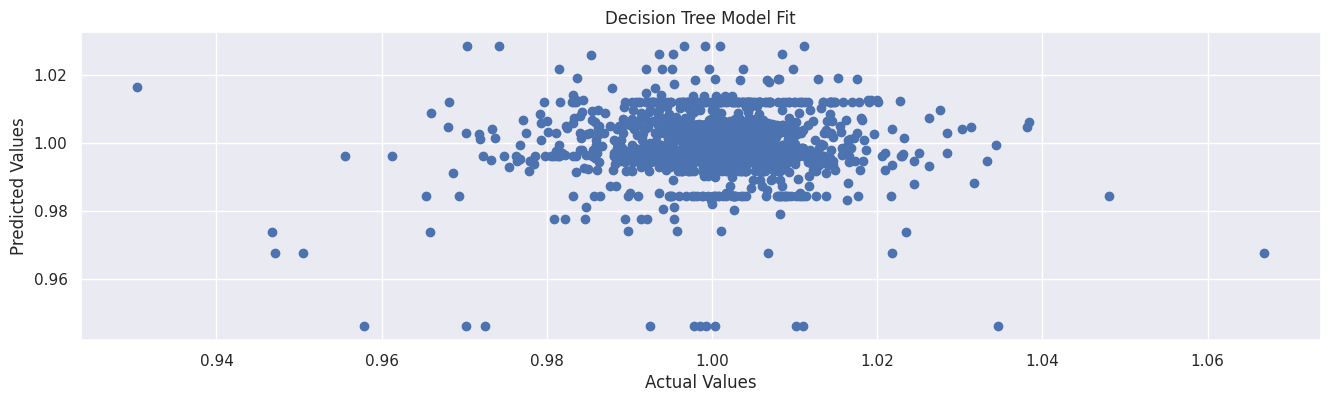

In [51]:
# Decision Tree Regression - Import library
from sklearn.tree import DecisionTreeRegressor

# Decision Tree Regression
dt_model = DecisionTreeRegressor()
dt_model.fit(x_train_scaled.reshape(x_train_scaled.shape[0], -1), y_train_scaled)
dt_pred = dt_model.predict(x_test_scaled.reshape(x_test_scaled.shape[0], -1))
dt_pred = scaler_y.inverse_transform(dt_pred.reshape(-1, 1))
dt_mse = np.mean((dt_pred - y_test)**2)

# Calculate R-squared and mean absolute error
dt_r2 = r2_score(y_test, dt_pred)
dt_mae = mean_absolute_error(y_test, dt_pred)

# Print Decision Tree Mean Squared Error, Mean Absolute Error, and R-squared
print('Decision Tree regression scores')
print('R-squared:', dt_r2)
print('MSE:', dt_mse)
print('MAE:', dt_mae)
print(f'RMSE: {rmse_calc(y_test, dt_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, dt_pred):.3f}')

perf = [{'Model': 'DT', 'Target': 'Pct', 'MSE': dt_mse, 'MAE': dt_mae, 'MAPE': mape_calc(y_test, dt_pred), 'RMSE': rmse_calc(y_test, dt_pred), 'R2': dt_r2}]
new_row = pd.DataFrame(perf)
perf_df = pd.concat([perf_df, new_row], ignore_index=True)


# Create scatterplot with model fit
plt.scatter(y_test, dt_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Model Fit')
plt.show()

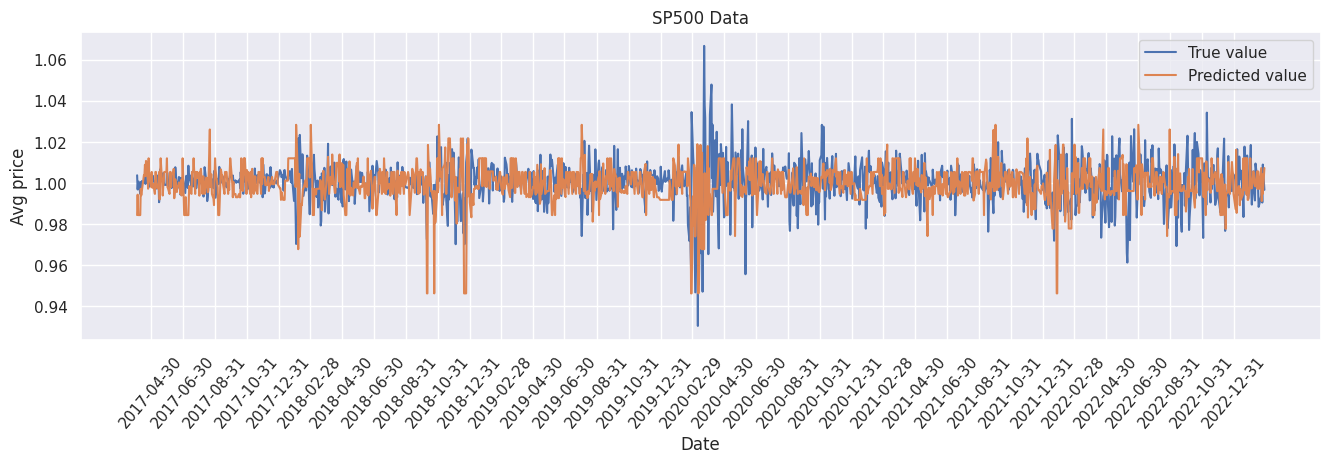

In [52]:
sns.lineplot(x=test_dates, y=y_test.flatten(), label=f'True value')
sns.lineplot(x=test_dates, y=dt_pred.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
#plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

### Gradient Boosting

/home/reedoken/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Grabient Boosting regression scores
MSE: 0.00010516139919680143
MAE: 0.006814282043514106
R-squared: -0.08425840727272238
RMSE: 0.010
MAPE: 0.007


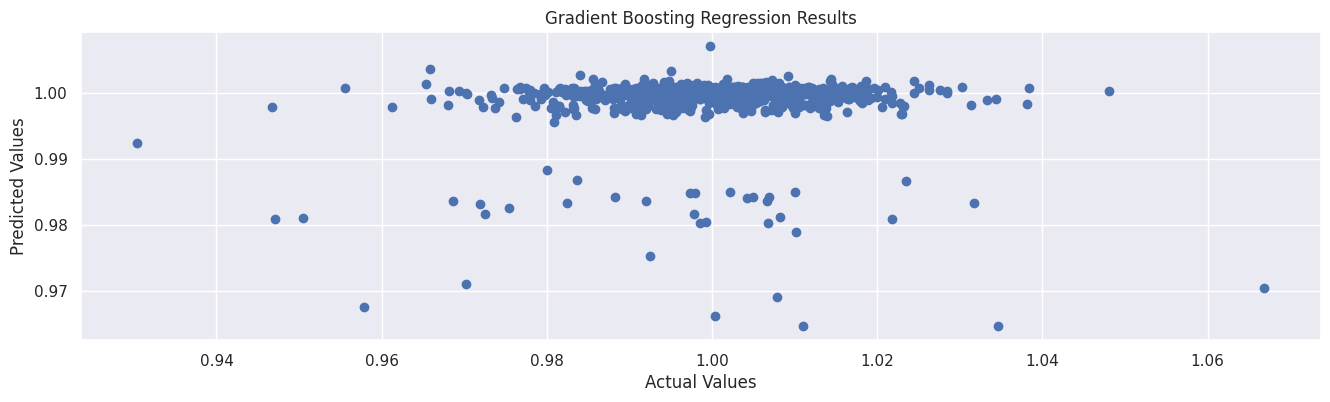

In [53]:
# Gradient Boosting Regression - Import library
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor(n_estimators=100)
gb_model.fit(x_train_scaled.reshape(x_train_scaled.shape[0], -1), y_train_scaled)
gb_pred = gb_model.predict(x_test_scaled.reshape(x_test_scaled.shape[0], -1))
gb_pred = scaler_y.inverse_transform(gb_pred.reshape(-1, 1))
gb_mse = np.mean((gb_pred - y_test)**2)

# Calculate R-squared and mean absolute error
gb_r2 = r2_score(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)

# Print Gradient Boosting Mean Squared Error, Mean Absolute Error, and R-squared
print('Grabient Boosting regression scores')
print('MSE:', gb_mse)
print('MAE:', gb_mae)
print('R-squared:', gb_r2)
print(f'RMSE: {rmse_calc(y_test, gb_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, gb_pred):.3f}')

perf = [{'Model': 'GB', 'Target': 'Pct', 'MSE': gb_mse, 'MAE': gb_mae, 'MAPE': mape_calc(y_test, gb_pred), 'RMSE': rmse_calc(y_test, gb_pred), 'R2': gb_r2}]
new_row = pd.DataFrame(perf)
perf_df = pd.concat([perf_df, new_row], ignore_index=True)

# Create scatterplot with model fit
plt.scatter(y_test, gb_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Gradient Boosting Regression Results')
plt.show()

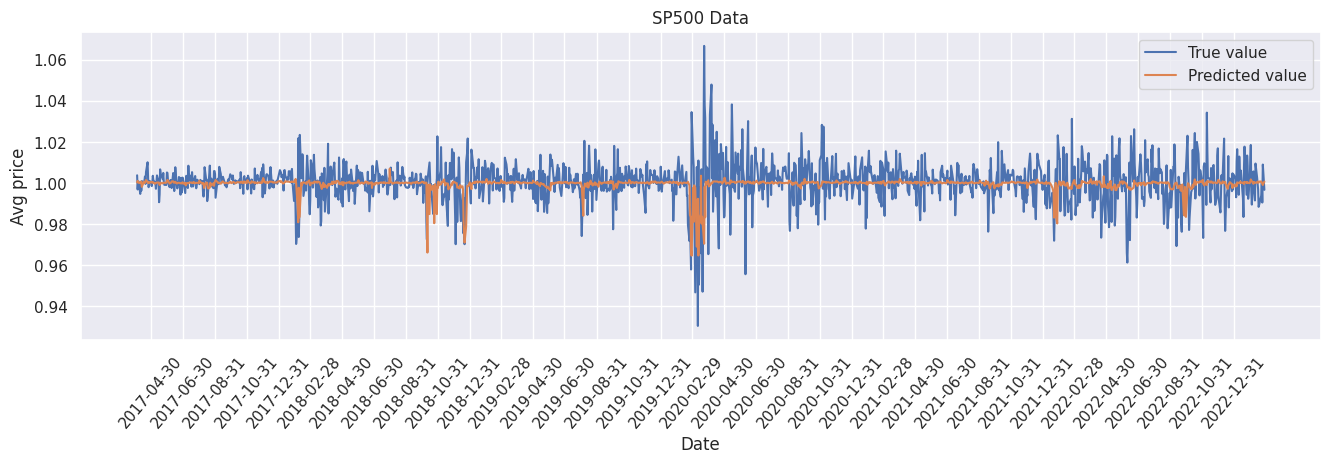

In [54]:
sns.lineplot(x=test_dates, y=y_test.flatten(), label=f'True value')
sns.lineplot(x=test_dates, y=gb_pred.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
#plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

### Random forest

Random Forest regression scores
R-squared: -0.04417665211900035
MSE: 0.00010127390021504918
MAE: 0.006932335519234915
RMSE: 0.010
MAPE: 0.007


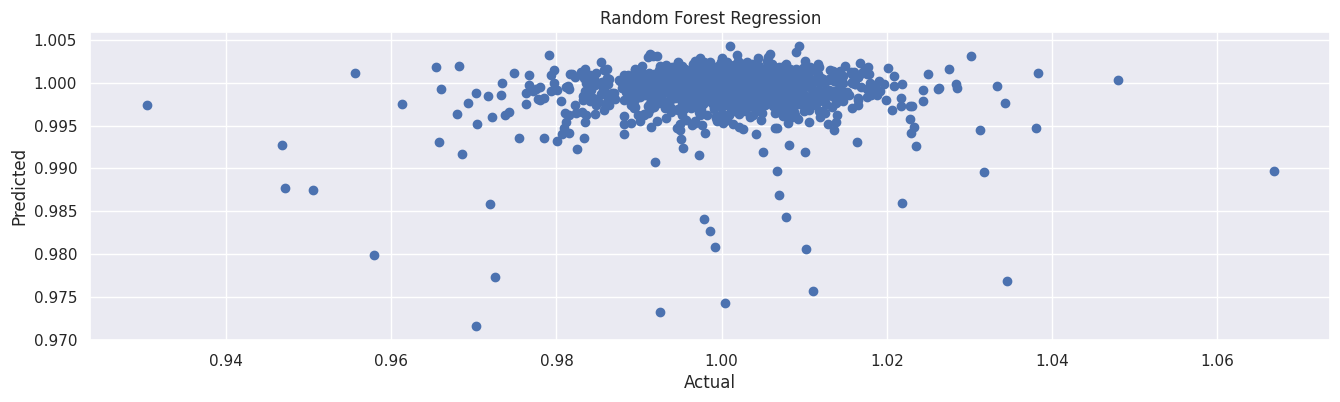

In [55]:
# Random Forest - Import library
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(x_train_scaled.reshape(x_train_scaled.shape[0], -1), y_train_scaled.ravel())
rf_pred = rf_model.predict(x_test_scaled.reshape(x_test_scaled.shape[0], -1))
rf_pred = scaler_y.inverse_transform(rf_pred.reshape(-1, 1))
rf_mse = np.mean((rf_pred - y_test)**2)

# Calculate R-squared and Mean Absolute Error
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

# Print Random Forest Mean Squared Error, Mean Absolute Error, and R-squared
print('Random Forest regression scores')
print('R-squared:', rf_r2)
print('MSE:', rf_mse)
print('MAE:', rf_mae)
print(f'RMSE: {rmse_calc(y_test, rf_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, rf_pred):.3f}')

perf = [{'Model': 'RF', 'Target': 'Pct', 'MSE': rf_mse, 'MAE': rf_mae, 'MAPE': mape_calc(y_test, rf_pred), 'RMSE': rmse_calc(y_test, rf_pred), 'R2': rf_r2}]
new_row = pd.DataFrame(perf)
perf_df = pd.concat([perf_df, new_row], ignore_index=True)

# Create scatterplot with model fit
plt.scatter(y_test, rf_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Regression")
plt.show()

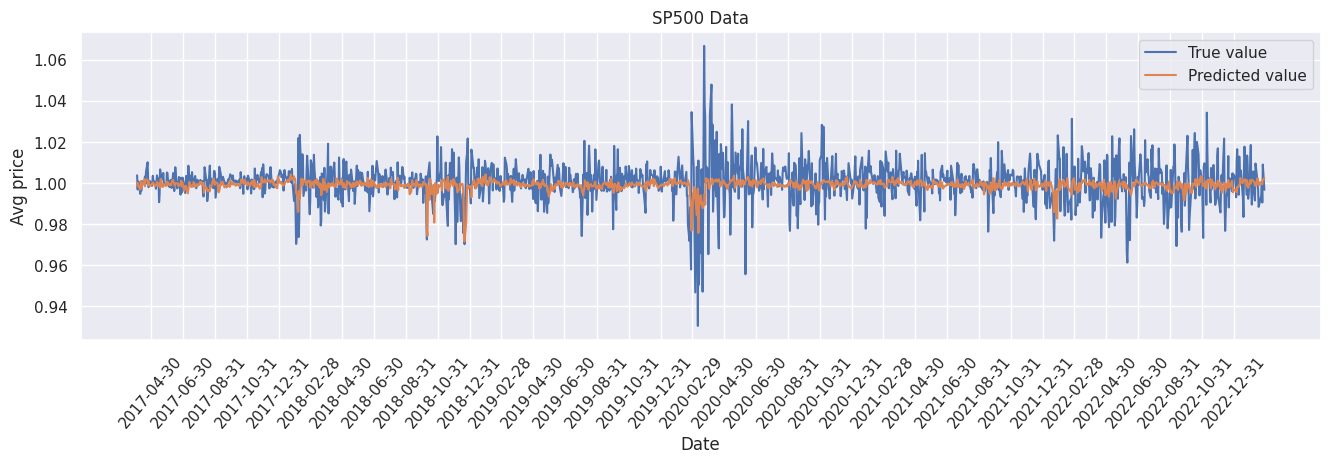

In [56]:
sns.lineplot(x=test_dates, y=y_test.flatten(), label=f'True value')
sns.lineplot(x=test_dates, y=rf_pred.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
#plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

In [57]:
perf_df.head(20)

,Model,Target,MSE,MAE,MAPE,RMSE,R2
0,LSTM,Price,545.693559,16.176854,0.042928,23.360085,NaN
1,LR,Price,7.866433,1.845412,0.005730,2.804716,0.998616
2,SVM,Price,2345.789956,44.343462,0.132029,48.433356,0.587242
3,SVM,Price,2345.789956,44.343462,0.132029,48.433356,0.587242
4,DT,Price,16686.242467,104.930362,0.290496,129.175239,-1.936058
5,GB,Price,16871.641553,105.813485,0.293410,129.890883,-1.968680
6,RF,Price,16831.535116,105.610202,0.292724,129.736406,-1.961623
7,LSTM,Pct,0.000113,0.007139,0.007175,0.010619,NaN
8,LR,Pct,0.000305,0.011236,0.011247,0.017451,-2.139990
9,SVM,Pct,0.000097,0.006564,0.006584,0.009862,-0.002780


In [58]:
#perf_df = perf_df.drop('R2', axis=1)
perf_df = perf_df.drop('Target', axis=1)

perf_df.head(20)

,Model,MSE,MAE,MAPE,RMSE,R2
0,LSTM,545.693559,16.176854,0.042928,23.360085,NaN
1,LR,7.866433,1.845412,0.005730,2.804716,0.998616
2,SVM,2345.789956,44.343462,0.132029,48.433356,0.587242
3,SVM,2345.789956,44.343462,0.132029,48.433356,0.587242
4,DT,16686.242467,104.930362,0.290496,129.175239,-1.936058
5,GB,16871.641553,105.813485,0.293410,129.890883,-1.968680
6,RF,16831.535116,105.610202,0.292724,129.736406,-1.961623
7,LSTM,0.000113,0.007139,0.007175,0.010619,NaN
8,LR,0.000305,0.011236,0.011247,0.017451,-2.139990
9,SVM,0.000097,0.006564,0.006584,0.009862,-0.002780


Percent difference = 

$P_{n+1} - P_n \over P_n$